# Import Statements

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import accuracy_score

# Generating dataset

In [4]:
def generateDataset(file_1, file_2, operation):
    data_1, data_2 = [], []

    with open(file_1, "rb") as f:
        for line in f.readlines():
            a1, a2 = map(float, line.decode('UTF-8').strip('\n').split())
            data_1.append((a1, a2))

    data_1=np.array(data_1)
    a1 = (data_1 - data_1.mean(axis=0))/data_1.std(axis=0)
    y1 = np.ones((a1.shape[0], 1), dtype='int')
    dataset_1 = np.hstack((a1, y1))


    with open(file_2, "rb") as f:
        for line in f.readlines():
            b1, b2 = map(float, line.decode('UTF-8').strip('\n').split())
            data_2.append((b1, b2))

    data_2=np.array(data_2)
    b1 = (data_2 - data_2.mean(axis=0))/data_2.std(axis=0)
    y2 = 2*np.ones((a1.shape[0], 1), dtype='int')
    dataset_2 = np.hstack((b1, y2))

    if operation == 'Training':
        return np.vstack((dataset_1[:1500, :], dataset_2[:1500, :]))
    elif operation == 'Validation':
        return np.vstack((dataset_1[1500:, :], dataset_2[1500:, :]))
    elif operation == 'Testing':
        return np.vstack((dataset_1, dataset_2))

training_data = generateDataset("Train1.txt", "Train2.txt", operation = "Training")
validation_data = generateDataset("Train1.txt", "Train2.txt", operation = "Validation")
testing_data = generateDataset("Test1.txt", "Test2.txt", operation = "Testing")

# MLP Architecture

> epoch: 1; learning_rate: 0.009; training_error: 0.2667723449473706; validation_error: 0.25886347107178154
> epoch: 2; learning_rate: 0.009; training_error: 0.2548186517317202; validation_error: 0.2569396634940344
> epoch: 3; learning_rate: 0.009; training_error: 0.25302546441626156; validation_error: 0.25526370843481716
> epoch: 4; learning_rate: 0.009; training_error: 0.25045472735939567; validation_error: 0.2520648252842204
> epoch: 5; learning_rate: 0.009; training_error: 0.24669652969123737; validation_error: 0.24890287748658388
> epoch: 6; learning_rate: 0.009; training_error: 0.23829041132015322; validation_error: 0.23941071495084093
> epoch: 7; learning_rate: 0.009; training_error: 0.23303720161826727; validation_error: 0.23694210075110733
> epoch: 8; learning_rate: 0.009; training_error: 0.23128659062373988; validation_error: 0.23599122004309311
> epoch: 9; learning_rate: 0.009; training_error: 0.23045660196500856; validation_error: 0.2353634619778452
> epoch: 10; learning_ra

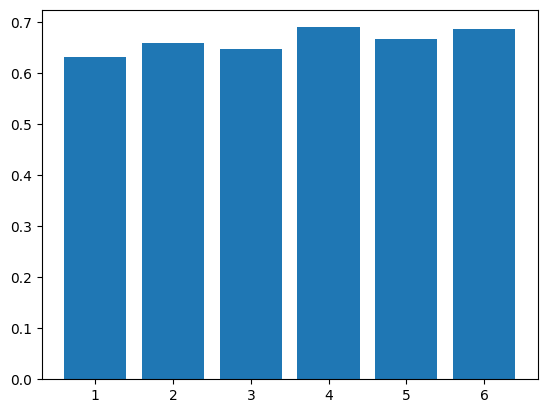

In [5]:
class MLP:
    def __init__(self, n_input=2, n_hidden=2, n_output=1):

        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_output = n_output

        self.training_data = None
        self.training_labels = None
        self.validation_data = None
        self.validation_labels = None
        self.testing_data = None
        self.testing_labels = None

        self.network = []
        self.__initialize_network()
        self.HIDDEN_LAYER_IDX = 0
        self.OUTPUT_LAYER_IDX = 1

    def __initialize_network(self):
        hidden_layer = [{'weights': np.random.rand(self.n_input+1)} for _ in range(self.n_hidden)]
        output_layer = [{'weights': np.random.rand(self.n_hidden+1)} for _ in range(self.n_output)]

        self.network.append(hidden_layer)
        self.network.append(output_layer)

    @staticmethod
    def __activation_function(value):
        return max(0, value)

    def __forward_prop(self, sample):
        inputs = np.hstack(([1], sample[:]))

        for layer in self.network:
            outputs = []
            for neuron in layer:
                neuron['output'] = self.__activation_function(np.dot(neuron['weights'], inputs))
                outputs.append(neuron['output'])

            inputs = np.hstack(([1], outputs[:]))
        return inputs[1:]


    @staticmethod
    def __compute_derivative(value):
        return 1 if value > 0 else 0

    def __back_prop(self, true_label):
        output_layer = self.network[self.OUTPUT_LAYER_IDX]

        for neuron in output_layer:
            error = true_label - neuron['output']
            neuron['delta'] = error * self.__compute_derivative(neuron['output'])

        hidden_layer = self.network[self.HIDDEN_LAYER_IDX]

        for n in range(len(hidden_layer)):
            error = 0.0
            for o_neuron in output_layer:
                error += o_neuron['weights'][n + 1] * o_neuron['delta']

            hidden_layer[n]['delta'] = error * self.__compute_derivative(hidden_layer[n]['output'])

    def __update_weights(self, sample, lr):
        inputs = np.hstack(([1], sample[:]))

        for layer in self.network:
            outputs = []
            for neuron in layer:
                neuron['weights'] += neuron['delta'] * inputs * lr
                outputs.append(neuron['output'])

            inputs = np.hstack(([1], outputs[:]))

    def __get_error(self, data, labels):
        total_error = 0.0
        for itr, sample in enumerate(data):
            output = self.__forward_prop(sample)
            ground_truth = labels[itr]
            total_error += np.sum(np.square(output - ground_truth))

        return total_error/data.shape[0]

    def __get_validation_error(self):
        return self.__get_error(self.validation_data, self.validation_labels)

    def __get_testing_error(self):
        return self.__get_error(self.testing_data, self.testing_labels)

    def train(self, learning_rate=9e-2, n_epochs=1000, batch_size=-1):
        epoch = 0
        training_error_history = []
        validation_error = float('inf')
        validation_error_history = []
        testing_error_history = []

        stopping_condition_met = False
        while not stopping_condition_met:
            epoch += 1
            training_error = 0.0
            for itr, sample in enumerate(self.training_data):
                output = self.__forward_prop(sample)
                ground_truth = self.training_labels[itr]
                training_error += np.sum(np.square(output - ground_truth))
                self.__back_prop(ground_truth)
                self.__update_weights(sample, learning_rate)

            training_error = training_error/self.training_data.shape[0]
            updated_val_error = self.__get_validation_error()
            testing_error = self.__get_testing_error()

            stopping_condition_met = np.isclose(validation_error, updated_val_error) or epoch >= n_epochs
            validation_error = updated_val_error
            print("> epoch: {}; learning_rate: {}; training_error: {}; validation_error: {}"
                  .format(epoch, learning_rate, training_error, validation_error))
            training_error_history.append(training_error)
            validation_error_history.append(validation_error)
            testing_error_history.append(testing_error)
        print("Finished training")
        print()

        plt.title("nH = {}".format(self.n_hidden))
        plt.xlabel("Epochs")
        plt.ylabel("Error")
        plt.plot(training_error_history, label="Training")
        plt.plot(validation_error_history, label="Validation")
        plt.plot(testing_error_history, label="Testing")
        plt.legend()
        figure = plt.gcf()
        # plt.show()

        filename = './Plot for nH = {}.png'.format(self.n_hidden)
        figure.savefig(filename, dpi=100)
        plt.close(figure)

    def predict(self, data):
        outputs = []
        for sample in data:
            outputs.append(np.round(self.__forward_prop(sample)[0]))

        return np.array(outputs)

    def save_weights(self):
        filename = 'MLP_nH_{}'.format(self.n_hidden)

        with open(filename, 'wb') as f:
            pickle.dump(self.network, f, protocol=pickle.HIGHEST_PROTOCOL)

        with open(filename + '.txt', 'w') as f:
            f.write(str(self.network))

    def load_weights(self):
        filename = 'MLP_nH_{}'.format(self.n_hidden)

        with open(filename, 'rb') as f:
            self.network = pickle.load(f)

    def __str__(self):
        return "MLP: nh= {}".format(self.n_hidden)


def train_and_test(multi_layer_perceptron):
    np.random.shuffle(training_data)
    x_train = training_data[:, :2]
    y_train = training_data[:, 2]

    multi_layer_perceptron.training_data = x_train
    multi_layer_perceptron.training_labels = y_train

    np.random.shuffle(validation_data)
    x_val = validation_data[:, :2]
    y_val = validation_data[:, 2]

    multi_layer_perceptron.validation_data = x_val
    multi_layer_perceptron.validation_labels = y_val

    x_test = testing_data[:, :2]
    y_test = testing_data[:, 2]

    multi_layer_perceptron.testing_data = x_test
    multi_layer_perceptron.testing_labels = y_test

    multi_layer_perceptron.train(learning_rate=9e-3)
    multi_layer_perceptron.save_weights()

    y_pred = multi_layer_perceptron.predict(x_test)
    accuracy_result = accuracy_score(y_test, y_pred)
    print("Accuracy on testing data: {}".format(accuracy_result))
    return accuracy_result


if __name__ == '__main__':
    avg_scores = []
    for i in range(4, 14 + 1, 2):
        scores = []
        for _ in range(5):
            mlp = MLP(n_input=2, n_hidden=i, n_output=1)
            score = train_and_test(mlp)
            scores.append(score)
        avg_scores.append(np.mean(scores))

    plt.bar(range(1, len(avg_scores) + 1), avg_scores)
    plt.show()

    with open('final_test_scores.txt', 'w') as f:
        f.write(str(avg_scores))